In [432]:
from IPython.display import Audio
import os
import numpy as np
import pandas as pd
import librosa
from librosa import display
import scipy
from sklearn import preprocessing
import matplotlib.pyplot as plt
audio_dir = os.getcwd()+"\\audio\\"
scaler = preprocessing.StandardScaler()
import sounddevice

%matplotlib inline

In [3]:
# Long example
file = audio_dir + "21966.mp3"

In [4]:
samples, sample_rate = librosa.load(file, sr=None)

C:\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


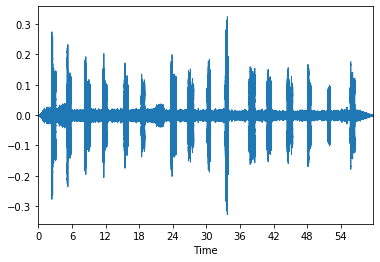

In [5]:
plt.figure()
display.waveplot(y=samples, sr=sample_rate)
plt.show()

In [6]:
sample_rate

44100

In [7]:
# Borrowed
def spectrogram(samples, sample_rate, stride_ms = 10, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

In [8]:
sg = spectrogram(samples, sample_rate, max_freq=10000)

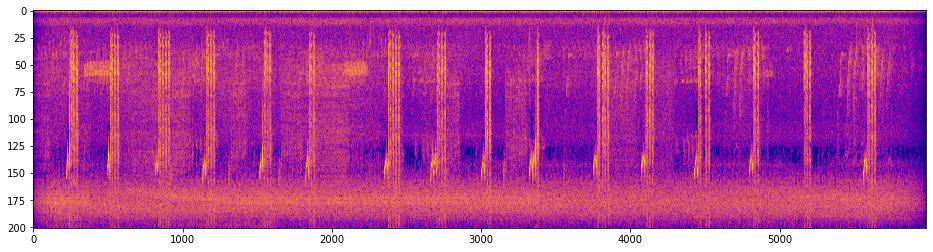

In [9]:
# Spectrogram
plt.figure(figsize=(16,4))
plt.imshow(sg, cmap='plasma', aspect='auto')
Audio(file)

In [10]:
sg.shape

(201, 5981)

In [11]:
print(np.min(sg))
print(np.average(sg))
print(np.max(sg))

-32.23617323153919
-22.662100524093987
-8.019367190974414


In [12]:
# Cut out first feature (lowest frequency) to make the size an even 200 px
sg = sg[1:,:]
# Transpose to have the right order for RNN
sg = np.transpose(sg)

In [13]:
# Standardize over time for each feature
sg = scaler.fit_transform(sg)
sg = np.transpose(sg)

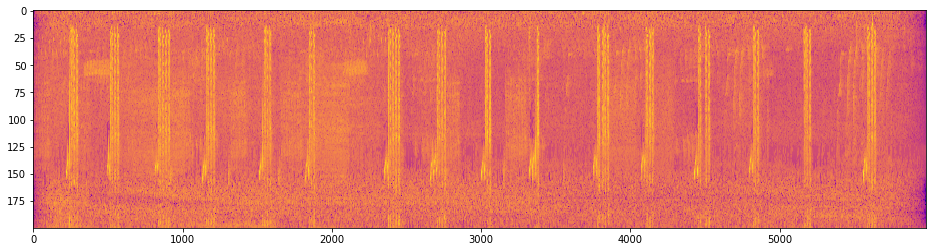

In [14]:
plt.figure(figsize=(16,4))
plt.imshow(sg, cmap='plasma', aspect='auto')

In [15]:
# Normalize rather than standardize this time
maxv = np.max(sg)
minv = np.min(sg)
sgn = 1 - (sg - minv)/(maxv - minv)

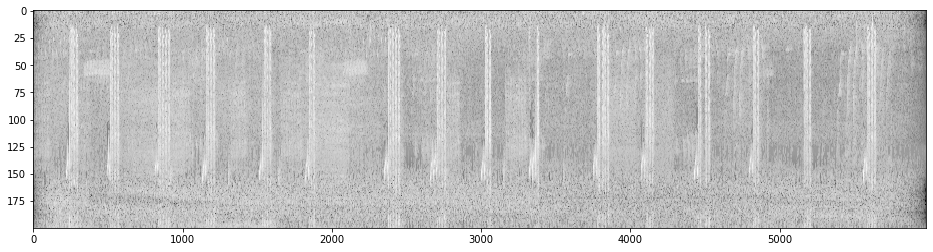

In [16]:
plt.figure(figsize=(16,4))
plt.imshow(sgn, cmap='Greys', aspect='auto')

In [17]:
# Mel-frequency cepstral coefficients have worked better for me for speech in the past.
# Bird songs are kind of like speech, so maybe?
# It's also much fewer features to work with.
mfcc = librosa.feature.mfcc(samples, sample_rate, n_mfcc=22)

In [18]:
mfcc.shape

(22, 5153)

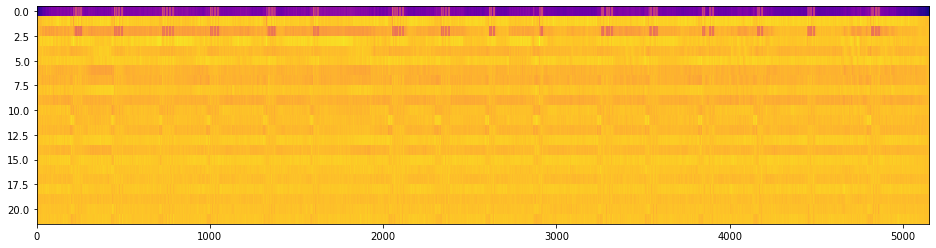

In [20]:
plt.figure(figsize=(16,4))
plt.imshow(mfcc, cmap='plasma', aspect='auto')
Audio(file)
# It actually looks like the first feature here is very important for determining which segments have the most energy.
# I can use that to my advantage, if I can figure out how to standardize it so that the main bird "talking" 
# is always above a certain threshold.

In [35]:
min0 = np.min(mfcc[0,:])
avg0 = np.mean(mfcc[0,:])
std0 = np.std(mfcc[0,:])
max0 = np.max(mfcc[0,:])
print(min0)
print(avg0)
print(std0)
print(max0)
# It seems like normalizing this over time would be useful.

-687.17474
-472.764
68.8241
-239.33646


In [36]:
mfcc0n = (mfcc[0,:] - min0)/(max0 - min0)

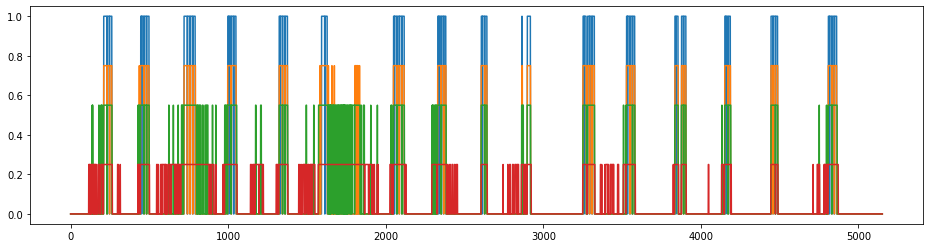

In [34]:
plt.figure(figsize=(16,4))
plt.plot(1*(mfcc[0,:] > avg0+std0))
plt.plot(0.75*(mfcc[0,:] > avg0+0.5*std0))
plt.plot(0.55*(mfcc[0,:] > avg0+0.25*std0))
plt.plot(0.25*(mfcc[0,:] > avg0+0*std0))

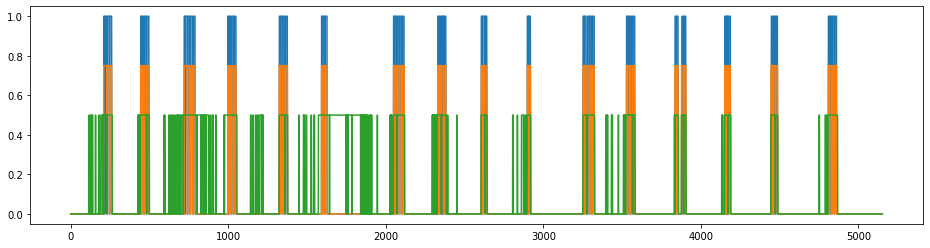

In [38]:
plt.figure(figsize=(16,4))
plt.plot(1*(mfcc0n > 0.75))
plt.plot(0.75*(mfcc0n > 0.66))
plt.plot(0.5*(mfcc0n > 0.5))
# It looks like 0.66 - 0.75 work here. I'd like to somehow decide on an appropriate threshold over all files...
# Though I guess the model would be learning the threshold anyway.

In [58]:
# Cut out the first four features, which have very large values
mfcc = mfcc[4:,:]
# This was a mistake!

-77.76428
1.3710696
76.90743
0	-50.53	18.76	65.69
1	-77.76	3.00	47.33
2	-38.80	0.36	74.70
3	-57.13	-1.10	74.72
4	-72.13	-1.07	32.47
5	-56.65	8.62	65.53
6	-55.77	0.43	54.03
7	-67.64	-7.28	60.61
8	-53.11	-0.08	59.71
9	-56.65	2.97	76.91
10	-41.45	-0.52	51.15
11	-52.55	-1.49	43.20
12	-38.14	-0.47	37.30
13	-35.94	-0.15	36.32
14	-29.81	0.95	33.26
15	-27.46	-0.61	26.30
16	-38.63	0.18	33.19
17	-33.76	2.19	33.20


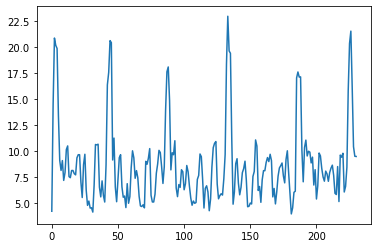

In [212]:
print(np.min(mfcc))
print(np.average(mfcc))
print(np.max(mfcc))
# How much energy is in each feature?
for i in range(mfcc.shape[0]):
    print('{0}\t{1:.2f}\t{2:.2f}\t{3:.2f}'.format(i, np.min(mfcc[i,:]), np.average(mfcc[i,:]), np.max(mfcc[i,:])))

# Seems that the first few features are very likely to be noise
binsize = 50
vals = []
for i in range(int(mfcc.shape[1]/binsize - 1)):
    vals.append(np.average(np.abs(mfcc[:,(binsize*i):(binsize*i)+binsize])))
# Can see the main bird here and the background birds have lower amplitudes...
plt.plot(vals)

In [214]:
# This seems to give a warning, but I'm not sure why. 
# Maybe it's because there are values which are more than 3 standard deviations away?
# The standard deviation isn't close to zero, in this case it's about 15...
scaled = scale(mfcc[0,:])
print(np.std(mfcc[0,:]))

15.410389


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [215]:
print(np.min(scaled))
print(np.average(scaled))
print(np.max(scaled))

-4.4962735
2.625394e-09
3.0451005


In [216]:
# Need the time axis to be the first dimension for RNNs
mfcct = np.transpose(mfcc)

# Standardize the features over time
scaled = scaler.fit_transform(mfcct)

In [62]:
# Normalize instead of standardizing
maxv = np.max(mfcc)
minv = np.min(mfcc)
mfccn = 2*(mfcc - minv)/(maxv - minv) - 1 # scale between -1 and 1

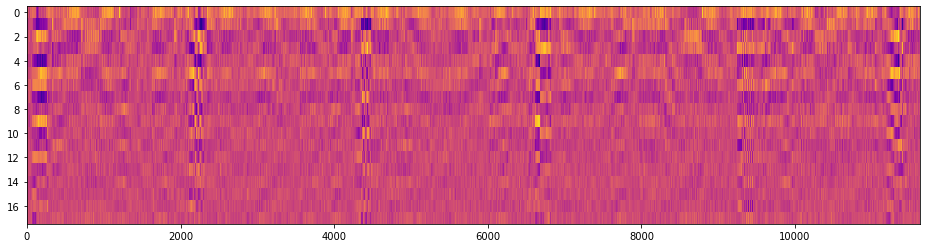

In [63]:
plt.figure(figsize=(16,4))
plt.imshow(mfccn, cmap='plasma', aspect='auto')

In [64]:
# Silent is close to 0.5 if normalized onto [0, 1].
mfccn[15,1000]
# Onto [-1, 1] makes more sense for MFCCs.

0.0037257671

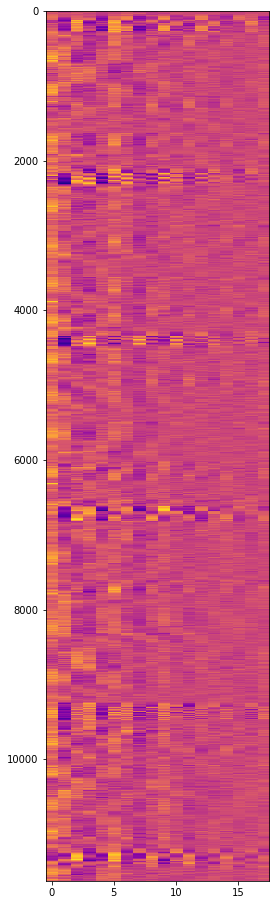

In [217]:
plt.figure(figsize=(4,16))
plt.imshow(mfcct, cmap='plasma', aspect='auto')
# Values close to zero are likely noise, now.

In [39]:
# Get a list of files in the folder
files = os.listdir('audio')

In [40]:
# Get class labels
bird_data = pd.read_csv('bird_recordings_texas_final.csv')
#bird_data['species'] = bird_data['species'].astype('str')

In [41]:
class_labels = np.asarray(pd.value_counts(bird_data['species']).axes[0])
bird_data[bird_data['id']==100144]['species'].iloc[0]

'Geothlypis trichas'

In [42]:
# Make MFCCs for all audio files
mfccs = []
characteristics = []
for i in range(len(files)):
    print('File', i)
    id_num = int(files[i][:-4])
    label = bird_data[bird_data['id']==id_num]['species'].iloc[0]
    print(label)
    samples, sample_rate = librosa.load('audio/'+files[i], sr=None)
    if sample_rate < 40100:
        # Don't use files with low sample rates (and therefore low quality)
        continue
    # Each example has [mfcc x, label y]. Convert to 16 bit floats to save on space.
    # I'm also going to throw in the number of time steps because otherwise it takes forever to count out.
    mfcc = librosa.feature.mfcc(samples, sample_rate, n_mfcc=22).astype('float16')
    # Normalize rather than standardize this time
    maxv = np.max(mfcc)
    minv = np.min(mfcc)
    mfccn = (mfcc - minv)/(maxv - minv) # scale between 0 and 1
    # Transpose to have the right order for RNN
    mfcct = np.transpose(mfccn)
    # Standardize over time for each feature
    #mfcct = scaler.fit_transform(mfcct)
    time_len = mfcct.shape[0]
    characteristics.append([np.min(mfcct), np.average(mfcct), np.max(mfcct), sample_rate])
    mfccs.append(np.asarray([mfcct, label, time_len]))

File 0
Geothlypis trichas


C:\Anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


File 1
Setophaga pitiayumi
File 2
Tympanuchus pallidicinctus
File 3
Tympanuchus pallidicinctus
File 4
Vireo atricapilla
File 5
Rallus elegans
File 6
Melanerpes aurifrons
File 7
Melanerpes aurifrons
File 8
Melanerpes aurifrons
File 9
Thryomanes bewickii
File 10
Mimus polyglottos
File 11
Baeolophus atricristatus
File 12
Aphelocoma wollweberi
File 13
Aphelocoma wollweberi
File 14
Leiothlypis crissalis
File 15
Leiothlypis crissalis
File 16
Icteria virens
File 17
Icteria virens
File 18
Aimophila ruficeps
File 19
Aimophila ruficeps
File 20
Poecile carolinensis
File 21
Mimus polyglottos
File 22
Peucaea aestivalis
File 23
Aimophila ruficeps
File 24
Arremonops rufivirgatus
File 25
Agelaius phoeniceus
File 26
Poecile carolinensis
File 27
Poecile carolinensis
File 28
Poecile carolinensis
File 29
Poecile carolinensis
File 30
Cyanocitta cristata
File 31
Thryothorus ludovicianus
File 32
Catherpes mexicanus
File 33
Thryothorus ludovicianus
File 34
Baeolophus atricristatus
File 35
Myiarchus cinerascen

File 289
Tympanuchus pallidicinctus
File 290
Poecile carolinensis
File 291
Spizella atrogularis
File 292
Myiarchus cinerascens
File 293
Myiarchus cinerascens
File 294
Spizella atrogularis
File 295
Spizella atrogularis
File 296
Spizella atrogularis
File 297
Myiarchus cinerascens
File 298
Myiarchus cinerascens
File 299
Leiothlypis crissalis
File 300
Baeolophus atricristatus
File 301
Leiothlypis crissalis
File 302
Leiothlypis crissalis
File 303
Leiothlypis crissalis
File 304
Leiothlypis crissalis
File 305
Vireo bellii
File 306
Vireo bellii
File 307
Myiarchus cinerascens
File 308
Baeolophus atricristatus
File 309
Baeolophus atricristatus
File 310
Baeolophus atricristatus
File 311
Baeolophus atricristatus
File 312
Polioptila caerulea
File 313
Spizella atrogularis
File 314
Mimus polyglottos
File 315
Mimus polyglottos
File 316
Passerina ciris
File 317
Aphelocoma wollweberi
File 318
Aphelocoma wollweberi
File 319
Aphelocoma wollweberi
File 320
Aphelocoma wollweberi
File 321
Aphelocoma wollwebe

In [224]:
characteristics = np.asarray(characteristics)
# Okay, I think I'll remove the ones with sample rates below 44100...
pd.value_counts(characteristics[:,3])

48000.0    295
44100.0    179
dtype: int64

(array([ 42.,  93., 129., 109.,  54.,  28.,  12.,   5.,   0.,   2.]),
 array([ 3.60351562,  4.28613281,  4.96875   ,  5.65136719,  6.33398438,
         7.01660156,  7.69921875,  8.38183594,  9.06445312,  9.74707031,
        10.4296875 ]),
 <a list of 10 Patch objects>)

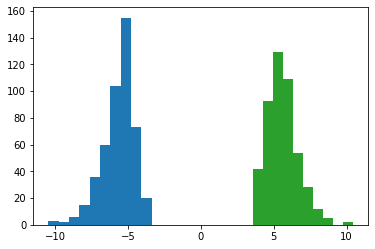

In [225]:
plt.hist(characteristics[:,0])
# plt.hist(characteristics[:,1]) # all zero
plt.hist(characteristics[:,2])

In [43]:
# Total size is about 122 MB
np.save('mfcc_data_normalized.npy', mfccs)

In [48]:
# Alternatively, I'll try using spectrograms... 
# They are much larger images, but perhaps it is easier to remove noise from them?
# Make spectrograms for all files
# Make MFCCs for all audio files
specs = []
spec_characteristics = []
max_freq = 10000
for i in range(len(files)):
    print('File', i)
    id_num = int(files[i][:-4])
    label = bird_data[bird_data['id']==id_num]['species'].iloc[0]
    print(label)
    samples, sample_rate = librosa.load('audio/'+files[i], sr=None)
    if sample_rate < 40100:
        # Don't use files with low sample rates (and therefore low quality)
        continue
    # Each example has [mfcc x, label y]. Convert to 16 bit floats to save on space.
    # I'm also going to throw in the number of time steps because otherwise it takes forever to count out.
    spec = spectrogram(samples, sample_rate, max_freq=max_freq).astype('float16')
    # Cut out first feature (lowest frequency) to make the size an even 200 px
    spec = spec[1:,:]
    # Normalize rather than standardize this time
    maxv = np.max(spec)
    minv = np.min(spec)
    specn = 1 - (spec - minv)/(maxv - minv)
    # Transpose to have the right order for RNN
    spect = np.transpose(specn)
    # Standardize over time for each feature
    #spect = scaler.fit_transform(spect)
    time_len = spect.shape[0]
    spec_characteristics.append([np.min(spect), np.average(spect), np.max(spect), sample_rate])
    specs.append(np.asarray([spect, label, time_len]))

File 0
Geothlypis trichas
File 1
Setophaga pitiayumi
File 2
Tympanuchus pallidicinctus
File 3
Tympanuchus pallidicinctus
File 4
Vireo atricapilla
File 5
Rallus elegans
File 6
Melanerpes aurifrons
File 7
Melanerpes aurifrons
File 8
Melanerpes aurifrons
File 9
Thryomanes bewickii
File 10
Mimus polyglottos
File 11
Baeolophus atricristatus
File 12
Aphelocoma wollweberi
File 13
Aphelocoma wollweberi
File 14
Leiothlypis crissalis
File 15
Leiothlypis crissalis
File 16
Icteria virens
File 17
Icteria virens
File 18
Aimophila ruficeps
File 19
Aimophila ruficeps
File 20
Poecile carolinensis
File 21
Mimus polyglottos
File 22
Peucaea aestivalis
File 23
Aimophila ruficeps
File 24
Arremonops rufivirgatus
File 25
Agelaius phoeniceus
File 26
Poecile carolinensis
File 27
Poecile carolinensis
File 28
Poecile carolinensis
File 29
Poecile carolinensis
File 30
Cyanocitta cristata
File 31
Thryothorus ludovicianus
File 32
Catherpes mexicanus
File 33
Thryothorus ludovicianus
File 34
Baeolophus atricristatus
Fi

File 288
Tympanuchus pallidicinctus
File 289
Tympanuchus pallidicinctus
File 290
Poecile carolinensis
File 291
Spizella atrogularis
File 292
Myiarchus cinerascens
File 293
Myiarchus cinerascens
File 294
Spizella atrogularis
File 295
Spizella atrogularis
File 296
Spizella atrogularis
File 297
Myiarchus cinerascens
File 298
Myiarchus cinerascens
File 299
Leiothlypis crissalis
File 300
Baeolophus atricristatus
File 301
Leiothlypis crissalis
File 302
Leiothlypis crissalis
File 303
Leiothlypis crissalis
File 304
Leiothlypis crissalis
File 305
Vireo bellii
File 306
Vireo bellii
File 307
Myiarchus cinerascens
File 308
Baeolophus atricristatus
File 309
Baeolophus atricristatus
File 310
Baeolophus atricristatus
File 311
Baeolophus atricristatus
File 312
Polioptila caerulea
File 313
Spizella atrogularis
File 314
Mimus polyglottos
File 315
Mimus polyglottos
File 316
Passerina ciris
File 317
Aphelocoma wollweberi
File 318
Aphelocoma wollweberi
File 319
Aphelocoma wollweberi
File 320
Aphelocoma wol

In [49]:
spec_characteristics = np.asarray(spec_characteristics)

In [50]:
pd.value_counts(spec_characteristics[:,3])

48000.0    295
44100.0    179
dtype: int64

(array([  0.,   0.,   0.,   0.,   0., 474.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

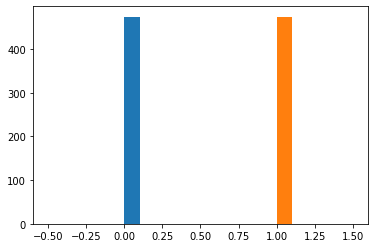

In [51]:
# plt.hist(spec_characteristics[:,0])
# plt.hist(spec_characteristics[:,1])
# plt.hist(spec_characteristics[:,2])

In [52]:
# Total size is about 1.4 GB
np.save('spec_data_normalized.npy', specs)

In [44]:
# Detect background noise level
# Use a threshold with the first MFCC feature with a small window to determine what is?
# considered good audio and what is silence between calls
# Either cut out the silent parts entirely or label the silent part as such
# Currently whole files have a given label, rather than parts of the audio, so the former option may be better
# It's possible that some bird calls have silence as a component, and have a characteristic length of pause
# But it can vary a lot, so it may not be the most useful feature anyway.
# Goal is to ensure that any chosen subclip of some fixed length (perhaps 2 seconds)
# will contain part of the main bird call and not just silence or background calls

In [460]:
# Examples: 383679*  220402  100144  81280  141344
file = audio_dir + "383679.mp3"
samples, sample_rate = librosa.load(file, sr=None)

In [461]:
# Fundamentally dominated by outliers - readjust std by excluding the outliers after a first run?
avgv = np.mean(samples)
stdv = np.std(samples)
print(avgv)
print("Noise level:", stdv)
reference = [avgv]*len(samples)
# Adjusted standard deviation, trying to exclude the "signal"
# Using 6 standard deviations...
stdv_adj = np.std(samples[np.abs(samples - avgv) < 6*stdv])
print("Adjusted noise level:", stdv_adj)

-8.2048035e-05
Noise level: 0.09086932
Adjusted noise level: 0.089210995


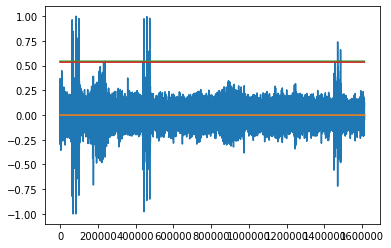

In [462]:
plt.plot(samples[0:])
plt.plot(reference[0:])
plt.plot(reference[0:] + 6*stdv)
plt.plot(reference[0:] + 6*stdv_adj)
# 6 standard deviations is hopefully enough to say with certainty what is signal vs noise here...
# But it looks like it's not quite perfect. There are still clicks and stuff that are problems.

In [463]:
# This is significantly faster than doing a convolution!
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#moving_average([1,2,3,4,5], 2)
#moving_average([1,2,3,4,5], 3)

In [464]:
# This clearly isn't the best way to find the true noise level.
# I'll try a moving average, to smooth out variations
n = 8000 # ~ 1/5 second
#smooth = np.convolve(abs(samples), [1/n for _ in range(n)])
smooth = moving_average(abs(samples), n)

Average: 0.06824876532849691
Noise: 0.03641931915283203
Signal: 0.1925627899169922
Noise factor: 0.20384743607845268


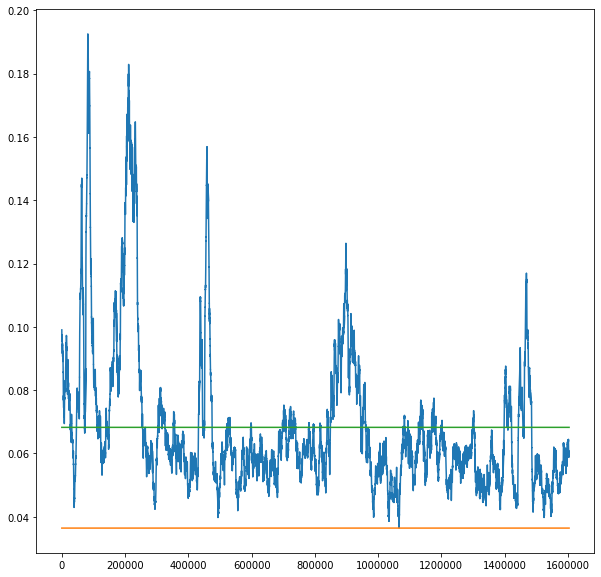

In [465]:
avg_level = np.mean(smooth[n:-n])
print("Average:", avg_level)
noise_level = np.min(smooth[n:-n])
print("Noise:", noise_level)
ref2 = np.asarray([noise_level] * len(smooth))
plt.figure(figsize=(10,10))
plt.plot(smooth)
plt.plot(ref2)
# This is a good minimum point for the noise, but a good maximum depends on the maximum signal.
signal_level = np.max(smooth[n:-n])
print("Signal:", signal_level)
# This seems to work well for relatively clean data but not for really noisy data
# Because the noise isn't fully smoothed by even this large a convolution...
noise_factor = (avg_level-noise_level)/(signal_level-noise_level)
print("Noise factor:", noise_factor)
# For very noisy data: 0.2
# For high signal data: 0.14
# For very clean data: 0.08
plt.plot(ref2 + noise_factor*(signal_level - noise_level))

0.0566410339242191
0.006443429005572685


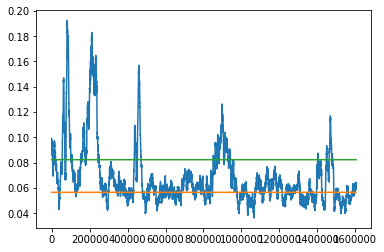

In [466]:
# I'm sure this is overestimated, but I really just need to get above the top of the noise level
probably_not_signal = smooth[smooth < noise_level + noise_factor*(signal_level-noise_level)]
avg2 = np.mean(probably_not_signal)
std2 = np.std(probably_not_signal)
print(avg2)
print(std2)
ref3 = np.repeat(avg2, len(smooth))
plt.plot(smooth)
plt.plot(ref3)
plt.plot(ref3 + 4*std2)
# This seems to work fairly well... Still has some clear false positives, though.

In [467]:
#mask = [0 for i in range(len(samples))]
signals = smooth > (avg2 + 4*std2)
print(np.sum(signals)/len(samples))
# pad so the lengths match
mask = np.pad((moving_average(signals, sample_rate) > 0), 
              (4000+sample_rate//2-1, 4000+sample_rate//2-1), 
              mode='constant').astype('bool')
print(len(samples))
print(len(mask))

0.16835153244819456
1611800
1611800


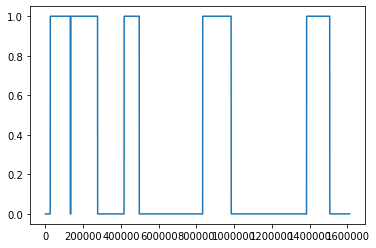

In [468]:
#plt.plot(signals)
plt.plot(mask.astype('int'))

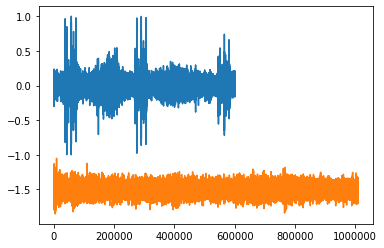

In [469]:
signal = samples[mask]
plt.plot(signal)
noise = samples[~mask]
plt.plot(noise-1.5)
# Could attempt to go further and apply denoising with this saved noise, but let's see how it does with just this first.

In [459]:
# There's a car in the background that is pretty annoyingly loud, ugh.
# And a click in another track...
# Can't fix everything.
sounddevice.play(signal, sample_rate)

In [ ]:
# The operations to remove the noisy parts:
"""
# In the loop
n = 8000 # ~ 1/5 second
smooth = moving_average(abs(samples), n)
avg_level = np.mean(smooth[n:-n])
noise_level = np.min(smooth[n:-n])
signal_level = np.max(smooth[n:-n])
noise_factor = (avg_level-noise_level)/(signal_level-noise_level)
probably_not_signal = smooth[smooth < noise_level + noise_factor*(signal_level-noise_level)]
avgv = np.mean(probably_not_signal)
stdv = np.std(probably_not_signal)
signals = smooth > (avgv + 4*stdv)
mask = np.pad((moving_average(signals, sample_rate) > 0), 
              (4000+sample_rate//2-1, 4000+sample_rate//2-1), 
              mode='constant').astype('bool')
signal = samples[mask]
"""

In [470]:
# Make MFCCs for all audio files
# With extra filtering

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

mfccs = []
characteristics = []
for i in range(len(files)):
    print('File', i)
    id_num = int(files[i][:-4])
    label = bird_data[bird_data['id']==id_num]['species'].iloc[0]
    print(label)
    samples, sample_rate = librosa.load('audio/'+files[i], sr=None)
    if sample_rate < 40100:
        # Don't use files with low sample rates (and therefore low quality)
        continue
    
    n = 8000 # ~ 1/5 second
    smooth = moving_average(abs(samples), n)
    avg_level = np.mean(smooth[n:-n])
    noise_level = np.min(smooth[n:-n])
    signal_level = np.max(smooth[n:-n])
    noise_factor = (avg_level-noise_level)/(signal_level-noise_level)
    probably_not_signal = smooth[smooth < noise_level + noise_factor*(signal_level-noise_level)]
    avgv = np.mean(probably_not_signal)
    stdv = np.std(probably_not_signal)
    signals = smooth > (avgv + 4*stdv)
    mask = np.pad((moving_average(signals, sample_rate) > 0), 
                  (4000+sample_rate//2-1, 4000+sample_rate//2-1), 
                  mode='constant').astype('bool')
    signal = samples[mask]
    mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=22).astype('float16')
    # Normalize rather than standardize this time
    maxv = np.max(mfcc)
    minv = np.min(mfcc)
    mfccn = (mfcc - minv)/(maxv - minv) # scale between 0 and 1
    # Transpose to have the right order for RNN
    mfcct = np.transpose(mfccn)
    # Standardize over time for each feature
    #mfcct = scaler.fit_transform(mfcct)
    time_len = mfcct.shape[0]
    characteristics.append([np.min(mfcct), np.average(mfcct), np.max(mfcct), sample_rate, noise_factor])
    mfccs.append(np.asarray([mfcct, label, time_len]))

File 0
Geothlypis trichas
File 1
Setophaga pitiayumi
File 2
Tympanuchus pallidicinctus
File 3
Tympanuchus pallidicinctus
File 4
Vireo atricapilla
File 5
Rallus elegans
File 6
Melanerpes aurifrons
File 7
Melanerpes aurifrons
File 8
Melanerpes aurifrons
File 9
Thryomanes bewickii
File 10
Mimus polyglottos
File 11
Baeolophus atricristatus
File 12
Aphelocoma wollweberi
File 13
Aphelocoma wollweberi
File 14
Leiothlypis crissalis
File 15
Leiothlypis crissalis
File 16
Icteria virens
File 17
Icteria virens
File 18
Aimophila ruficeps
File 19
Aimophila ruficeps
File 20
Poecile carolinensis
File 21
Mimus polyglottos
File 22
Peucaea aestivalis
File 23
Aimophila ruficeps
File 24
Arremonops rufivirgatus
File 25
Agelaius phoeniceus
File 26
Poecile carolinensis
File 27
Poecile carolinensis
File 28
Poecile carolinensis
File 29
Poecile carolinensis
File 30
Cyanocitta cristata
File 31
Thryothorus ludovicianus
File 32
Catherpes mexicanus
File 33
Thryothorus ludovicianus
File 34
Baeolophus atricristatus
Fi

File 288
Tympanuchus pallidicinctus
File 289
Tympanuchus pallidicinctus
File 290
Poecile carolinensis
File 291
Spizella atrogularis
File 292
Myiarchus cinerascens
File 293
Myiarchus cinerascens
File 294
Spizella atrogularis
File 295
Spizella atrogularis
File 296
Spizella atrogularis
File 297
Myiarchus cinerascens
File 298
Myiarchus cinerascens
File 299
Leiothlypis crissalis
File 300
Baeolophus atricristatus
File 301
Leiothlypis crissalis
File 302
Leiothlypis crissalis
File 303
Leiothlypis crissalis
File 304
Leiothlypis crissalis
File 305
Vireo bellii
File 306
Vireo bellii
File 307
Myiarchus cinerascens
File 308
Baeolophus atricristatus
File 309
Baeolophus atricristatus
File 310
Baeolophus atricristatus
File 311
Baeolophus atricristatus
File 312
Polioptila caerulea
File 313
Spizella atrogularis
File 314
Mimus polyglottos
File 315
Mimus polyglottos
File 316
Passerina ciris
File 317
Aphelocoma wollweberi
File 318
Aphelocoma wollweberi
File 319
Aphelocoma wollweberi
File 320
Aphelocoma wol

(array([ 92., 163., 107.,  64.,  22.,  16.,   5.,   3.,   1.,   1.]),
 array([0.01011637, 0.06486024, 0.1196041 , 0.17434796, 0.22909183,
        0.28383569, 0.33857955, 0.39332342, 0.44806728, 0.50281114,
        0.55755501]),
 <a list of 10 Patch objects>)

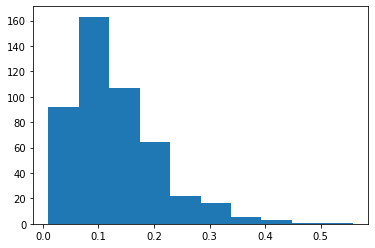

In [477]:
characteristics = np.asarray(characteristics)
plt.hist(characteristics[:,4]) # Noise factor

In [478]:
# Total size is about 59 MB
np.save('mfcc_data_filtered.npy', mfccs)

In [479]:
# I wonder which one had over 0.5 noise factor...
np.argmax(characteristics[:,4])

464

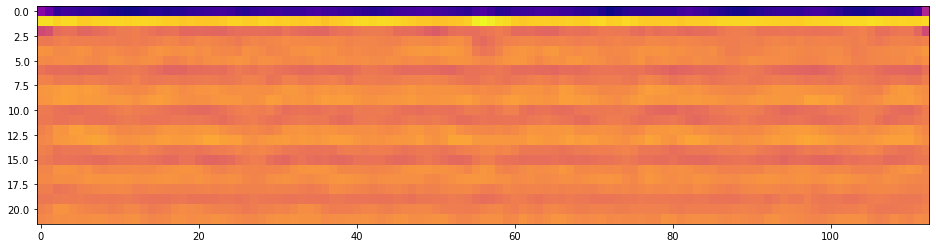

In [492]:
plt.figure(figsize=(16,4))
plt.imshow(np.transpose(mfccs[464][0]).astype('float32'), cmap='plasma', aspect='auto')
# Wow, this is completely unusable. Guess I'll make sure to remove the files filtered to being too short.
# It's also tempting to remove the files that have too high a noise factor.

In [489]:
samples, sample_rate = librosa.load('audio/'+files[464], sr=None)

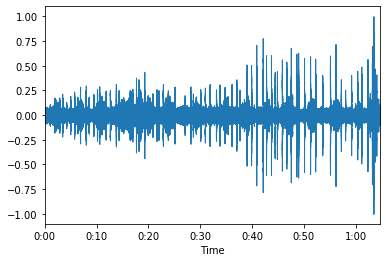

In [491]:
display.waveplot(samples, sample_rate)
sounddevice.play(samples, sample_rate)